In [1]:
import pandas as pd
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize

## Data Manipulation

In [44]:
character_metadata = pd.read_csv('/Users/user/Desktop/MovieSummaries/character.metadata.tsv', sep='\t', names=[
    'movie_id', 'freebase_id', 'release_date', 'character_name', 'actor_dob', 'actor_gender', 
    'actor_height', 'actor_ethnicity', 'actor_name', 'actor_age', 'character_actor_map_id', 
    'character_freebase_id', 'actor_freebase_id'
])
plot_summaries = pd.read_csv('/Users/user/Desktop/MovieSummaries/plot_summaries.txt', sep='\t', names=['movie_id', 'plot_summary'])

For this analysis, the only relevant columns are 'movie_id' and 'character_name', as they allow us to effectively study the characters in relation to the plot summaries of their respective movies.

In [45]:
# Keep only relevant columns
character_data = character_metadata.loc[:, ['movie_id', 'character_name']]
character_data.head()

,movie_id,character_name
0,975900,Akooshay
1,975900,Lieutenant Melanie Ballard
2,975900,Desolation Williams
3,975900,Sgt Jericho Butler
4,975900,Bashira Kincaid


In [112]:
# Merge plot summaries and character data on movie_id
merged_data = pd.merge(plot_summaries, character_data, on='movie_id')
merged_data

,movie_id,plot_summary,character_name
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",NaN
1,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",NaN
2,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",NaN
3,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",NaN
4,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",NaN
...,...,...,...
308480,6040782,1940 - Operation Dynamo has just taken place. ...,NaN
308481,6040782,1940 - Operation Dynamo has just taken place. ...,NaN
308482,6040782,1940 - Operation Dynamo has just taken place. ...,NaN
308483,6040782,1940 - Operation Dynamo has just taken place. ...,NaN


In [47]:
# Drop NaN values
merged_data_clean = merged_data.dropna(subset=['character_name']).reset_index(drop=True)
merged_data_clean

,movie_id,plot_summary,character_name
0,31186339,The nation of Panem consists of a wealthy Capi...,Foxface
1,31186339,The nation of Panem consists of a wealthy Capi...,Katniss Everdeen
2,31186339,The nation of Panem consists of a wealthy Capi...,Peeta Mellark
3,31186339,The nation of Panem consists of a wealthy Capi...,Effie Trinket
4,31186339,The nation of Panem consists of a wealthy Capi...,Gale Hawthorne
...,...,...,...
142411,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...",Amina A. Khan
142412,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...",Neelam Bai
142413,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...",Raj Varma
142414,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...",Manoj Mukherjee


Since some characters are not mentioned in the plot summaries, here, we will exclude them from our data, as no meaningful analysis can be conducted on them.

In [113]:
# Keep characters that are mentioned in the plot summary
characters_in_plot = merged_data_clean.copy()
# Define a lambda function to check if any part of the character name is in the plot summary
characters_in_plot = characters_in_plot[characters_in_plot.apply(
    lambda row: any(part.lower() in row['plot_summary'].lower() for part in row['character_name'].split()),
    axis=1
)].reset_index(drop=True)


characters_in_plot

,movie_id,plot_summary,character_name
0,31186339,The nation of Panem consists of a wealthy Capi...,Foxface
1,31186339,The nation of Panem consists of a wealthy Capi...,Katniss Everdeen
2,31186339,The nation of Panem consists of a wealthy Capi...,Peeta Mellark
3,31186339,The nation of Panem consists of a wealthy Capi...,Haymitch Abernathy
4,31186339,The nation of Panem consists of a wealthy Capi...,Clove
...,...,...,...
80948,17208834,A high school prom in Georgia is unexpectedly ...,Steven
80949,17208834,A high school prom in Georgia is unexpectedly ...,Kyle Grubbin
80950,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...",Abdul Rehman Khan
80951,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...",Mini


Here, we extract a unique context for each character by identifying where they are specifically mentioned within the plot summary. This can be used for further analysis.

In [114]:
# Extract character-specific sentences and create character context column
import nltk
nltk.download('punkt')

def extract_character_context(row):
    character_name_parts = row['character_name'].split()  # Split the character name into parts
    plot_summary = row['plot_summary']
    
    # Split plot summary into sentences
    sentences = nltk.sent_tokenize(plot_summary)
    
    # Filter sentences that mention any part of the character's name
    character_sentences = [
        sentence for sentence in sentences 
        if any(part.lower() in sentence.lower() for part in character_name_parts)
    ]
    
    # Combine relevant sentences back into a shorter summary focused on the character
    return ' '.join(character_sentences)

# Apply the function to create a character-specific context
characters_in_plot['character_context'] = characters_in_plot.apply(extract_character_context, axis=1)

# View the updated DataFrame to check character-specific contexts
characters_in_plot[['character_name', 'character_context']]

[nltk_data] Downloading package punkt to /Users/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,character_name,character_context
0,Foxface,"Foxface, the girl from District 5, dies from e..."
1,Katniss Everdeen,"In her first Reaping, 12-year-old Primrose Eve..."
2,Peeta Mellark,"Peeta Mellark, a baker's son who once gave Kat..."
3,Haymitch Abernathy,"Katniss and Peeta are taken to the Capitol, ac..."
4,Clove,Clove ambushes her and pins her down. As Clove...
...,...,...
80948,Steven,"As zombies march on the high school, a motley ..."
80949,Kyle Grubbin,"As zombies march on the high school, a motley ..."
80950,Abdul Rehman Khan,"Abdur Rehman Khan , a middle-aged dry fruit se..."
80951,Mini,"Abdur Rehman Khan , a middle-aged dry fruit se..."


## Vader Sentiment Analysis

We begin by conducting a VADER sentiment analysis on our characters to gain an initial understanding of the overall sentiment surrounding each one. Each character will be assigned a 'sentiment score' based on the analysis of their plot summaries. This score, known as the 'compound score,' provides a measure of overall sentiment, ranging from -1 (most negative) to +1 (most positive).

In [119]:
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()
vader_data = characters_in_plot.copy()

# Define a function to extract character-centric sentiment, considering partial character name matches
def character_sentiment_extraction(row):
    character_name_parts = row['character_name'].split()  # Split the character name into parts
    plot_summary = row['plot_summary']
    
    # Split the plot summary into sentences
    sentences = nltk.sent_tokenize(plot_summary)
    
    # Filter sentences that mention any part of the character's name
    relevant_sentences = [
        sentence for sentence in sentences 
        if any(part.lower() in sentence.lower() for part in character_name_parts)
    ]
    
    # If relevant sentences are found, calculate the average sentiment score
    if relevant_sentences:
        scores = [sia.polarity_scores(sentence)['compound'] for sentence in relevant_sentences]
        return sum(scores) / len(scores)
    else:
        return None

# Apply the function to each row of the DataFrame
vader_data['character_sentiment_score'] = vader_data.apply(character_sentiment_extraction, axis=1)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/user/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [120]:
#drop Nans
vader_data.dropna()
vader_data[['character_name', 'character_sentiment_score']]

,character_name,character_sentiment_score
0,Foxface,-0.611500
1,Katniss Everdeen,-0.242828
2,Peeta Mellark,-0.197344
3,Haymitch Abernathy,-0.488550
4,Clove,-0.418000
...,...,...
80948,Steven,0.011117
80949,Kyle Grubbin,-0.291233
80950,Abdul Rehman Khan,0.100629
80951,Mini,0.086400


### Classifying characters

We will start with a simple classification of our characters to identify the 'villain' archetypes. By selecting a threshold for the sentiment scores, we classify each character as either a villain or not based on their sentiment.

In [121]:
# Function to classify a character as 'Villain' or 'Not Villain' based on sentiment score
def classify_villain_via_sentiment(row):
    score = row['character_sentiment_score']
    
    # Define threshold for villain classification
    # Characters with highly negative sentiment scores are classified as 'Villain'
    if score is not None and score < -0.3:  # Adjust this threshold based on observations
        return 'Villain'
    else:
        return 'Not Villain'

# Apply the function to each row in the DataFrame
vader_data['villain_classification'] = vader_data.apply(classify_villain_via_sentiment, axis=1)

# View the updated DataFrame
vader_data[['character_name', 'villain_classification']]


,character_name,villain_classification
0,Foxface,Villain
1,Katniss Everdeen,Not Villain
2,Peeta Mellark,Not Villain
3,Haymitch Abernathy,Villain
4,Clove,Villain
...,...,...
80948,Steven,Not Villain
80949,Kyle Grubbin,Not Villain
80950,Abdul Rehman Khan,Not Villain
80951,Mini,Not Villain


### What's a Sympathetic Villain?

This is an initial approach to identifying sympathetic villains. Here, we aim to find common ground between the villain archetype and traits that make them more relatable, engaging, or sympathetic. We attempt to identify contextual elements, such as trauma, loss, or being misunderstood, which could contribute to portraying the villain in a more sympathetic light.

In [82]:
# Filtering for potential sympathetic villains
sympathetic_villains = vader_data[
    (vader_data['villain_classification'] == "Villain") &
    (vader_data['plot_summary'].str.contains('sympathy|tragedy|struggle|misunderstood|loss|trauma', case=False)) #can change condition
]

In [ ]:
print("Potential Sympathetic Villains:")
sympathetic_villains.loc[:, ['character_name', 'character_sentiment_score']]

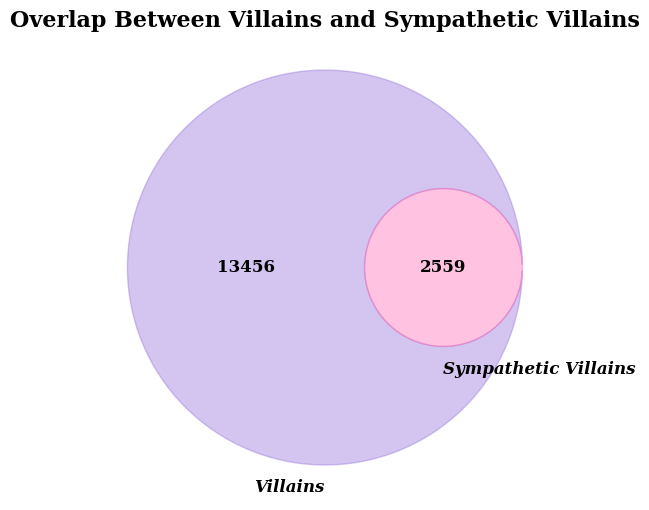

In [109]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
from matplotlib import font_manager

# Number of villains
num_villains = len(vader_data[vader_data['villain_classification'] == 'Villain'])

# Number of sympathetic villains (all of which are villains)
num_sympathetic_villains = len(sympathetic_villains)

# Create a Venn diagram
plt.figure(figsize=(6, 8))
venn = venn2(subsets=(
    num_villains - num_sympathetic_villains,  # Only villains
    0,  # Only sympathetic villains (none in this case)
    num_sympathetic_villains  # Villains that are also sympathetic
), set_labels=('Villains', 'Sympathetic Villains'))

# Set colors for each subset
venn.get_patch_by_id('10').set_color('#9370DB')  # Only villains (red)
venn.get_patch_by_id('11').set_color('#FF69B4')  # Villains that are also sympathetic (highlighted in brown)

# Remove the text label for empty subset
if venn.get_label_by_id('01') is not None:
    venn.get_label_by_id('01').set_text('')

# Set font properties for the labels
font_properties = font_manager.FontProperties(family='serif', style='italic', weight='bold', size=12)

# Update the set labels ("Villains", "Sympathetic Villains")
venn.get_label_by_id('A').set_fontproperties(font_properties)
venn.get_label_by_id('B').set_fontproperties(font_properties)

# Update subset label fonts (numbers within the diagram)
for subset_id in ('10', '11'):
    if venn.get_label_by_id(subset_id) is not None:
        venn.get_label_by_id(subset_id).set_fontsize(12)
        venn.get_label_by_id(subset_id).set_fontweight('bold')
        venn.get_label_by_id(subset_id).set_family('serif')

# Set title for the plot with custom font
plt.title('Overlap Between Villains and Sympathetic Villains', fontsize=16, fontweight='bold', family='serif')

# Display the plot
plt.show()


## Transformer Sentiment Analysis

In [128]:
"""
from transformers import pipeline

transformer_data = characters_in_plot.copy()

# Load a pre-trained emotion detection pipeline
emotion_pipeline = pipeline('sentiment-analysis', model='j-hartmann/emotion-english-distilroberta-base')

# Define a function to extract emotion scores for sentences related to the character
def extract_character_emotions(row):
    character_name_parts = row['character_name'].split()
    plot_summary = row['plot_summary']
    
    # Extract sentences that mention the character
    sentences = nltk.sent_tokenize(plot_summary)
    relevant_sentences = [
        sentence for sentence in sentences 
        if any(part.lower() in sentence.lower() for part in character_name_parts)
    ]

    # Extract emotions from relevant sentences
    if relevant_sentences:
        emotions = emotion_pipeline(relevant_sentences)
        # Find predominant emotion (or most frequent)
        emotion_counts = {}
        for emotion in emotions:
            label = emotion['label']
            emotion_counts[label] = emotion_counts.get(label, 0) + 1
        
        return max(emotion_counts, key=emotion_counts.get)
    else:
        return None

# Apply emotion extraction to the DataFrame
transformer_data['predominant_emotion'] = transformer_data.apply(extract_character_emotions, axis=1)
transformer_data
"""

"\nfrom transformers import pipeline\n\ntransformer_data = characters_in_plot.copy()\n\n# Load a pre-trained emotion detection pipeline\nemotion_pipeline = pipeline('sentiment-analysis', model='j-hartmann/emotion-english-distilroberta-base')\n\n# Define a function to extract emotion scores for sentences related to the character\ndef extract_character_emotions(row):\n    character_name_parts = row['character_name'].split()\n    plot_summary = row['plot_summary']\n    \n    # Extract sentences that mention the character\n    sentences = nltk.sent_tokenize(plot_summary)\n    relevant_sentences = [\n        sentence for sentence in sentences \n        if any(part.lower() in sentence.lower() for part in character_name_parts)\n    ]\n\n    # Extract emotions from relevant sentences\n    if relevant_sentences:\n        emotions = emotion_pipeline(relevant_sentences)\n        # Find predominant emotion (or most frequent)\n        emotion_counts = {}\n        for emotion in emotions:\n         

In [131]:
"""
# Drop rows where predominant_emotion is None
filtered_trans_data = transformer_data[transformer_data['predominant_emotion'].notna()].reset_index(drop=True)

# Display the filtered DataFrame
filtered_trans_data
"""

"\n# Drop rows where predominant_emotion is None\nfiltered_trans_data = transformer_data[transformer_data['predominant_emotion'].notna()].reset_index(drop=True)\n\n# Display the filtered DataFrame\nfiltered_trans_data\n"

## Conclusion:
This work represents an initial step towards identifying sympathetic villains through sentiment analysis. Our preliminary findings already reveal that some villains possess contextual backgrounds—such as personal loss, being misunderstood, or morally complex decisions—that make them more relatable and emotionally compelling to audiences. These early observations indicate that sympathy for a villain often stems from narratives that blur the lines between good and evil, showing the humanity behind their actions.

However, to gain a truly comprehensive understanding of what makes a villain sympathetic, more in-depth analysis is needed. Future work could leverage advanced NLP models  to capture subtler emotional cues that sentiment scores may overlook.